## Poject 2: 

### I. Summary Business Questions

1. How many assesstments are in the dataset?
2. What's the name of your Kafka topic? How did you come up with that name?
3. How many people took *Learning Git*?
4. What is the least common course taken? 
5. What is the most common course taken?
6. What are the tests with the highest percent of correct questions?
7. What are the tests with the lowest percent of correct questions?

### II. Executive Summary
For this report, a dataset of test for 103 courses taken between November 2017 and January 2018 was evaluated.  This dataset includes 3280 observations of people taken the courses. The dataset was downloaded from the internet with the following command:

```
curl -L -o assessment-attempts-20180128-121051-nested.json https://goo.gl/ME6hjp
```

Once the JSON file was downloaded, the data was analyzed using pyspark/spark.sql which read information sent through a 'kafka' topic called 'examtaken', as the dataset includes information of the exams (assessments) associated to (103) courses.

The top 5 (most common) courses in the dataset are presented in the following table:

```
+--------------------+--------+                                                 
|           exam_name|num_exam|
+--------------------+--------+
|        Learning Git|     394|
|Introduction to P...|     162|
|Intermediate Pyth...|     158|
|Introduction to J...|     158|
|Learning to Progr...|     128|
+--------------------+--------+
```

The most common course is "Learning Git", which was taken by 394 people. Perhaps, aligned with the current trend of professionals looking to up-skill in datascience related topics, three out of the top five courses are related to learning Python and R, which are two of the most popular programming languages for someone seeking to get into the datascience field. In addition, these top courses are mostly introductory and/or intermediate level, which may also explain their popularity, as they are apealing to a larger segment of potential customers.  In essence, these course are directed to customers seeking introductory to intermediate level of educations for Git, Python, R and Java.

The least common courses (bottom 5) are presented in the following table:
```
+--------------------+--------+                                                 
|           exam_name|num_exam|
+--------------------+--------+
|Nulls, Three-valu...|       1|
|Native Web Apps f...|       1|
|Learning to Visua...|       1|
|Operating Red Hat...|       1|
|Understanding the...|       2|
+--------------------+--------+
```
These list of courses (least common) are more on the technical side, and they do not seem to be introductory courses which may also explain the small number of participants taking them. In addition, their topics may not be as popular as introductory datascience related topics.

The courses with the lowest percent of correct questions are:
```
+--------------------+--------+------------------+                              
|           exam_name|num_exam|           percent|
+--------------------+--------+------------------+
|Example Exam For ...|       5|              null|
|Client-Side Data ...|       2|               0.2|
|Native Web Apps f...|       1|              0.25|
|       View Updating|       4|              0.25|
|Arduino Prototypi...|       2|0.3333333333333333|
+--------------------+--------+------------------+
```
The above table present courses which should be reviewed to ensure the customer experience is adequate.  While it is important that participants demonstrate what they have learned with a test, low scores may further discourage them for recommending the courses (if test is too difficult).  In addition, low scores may also reflect a decrease in the interest of the course, or misalignment between what is been presented in the course and what is being evaluated.  Thus, these courses should be further reviewed to identify potential causes for the low scores, and to identify ways in which the customer experience may be improved.

The courses with the highest percent of correct questions area:

```
+--------------------+--------+------------------+                              
|           exam_name|num_exam|           percent|
+--------------------+--------+------------------+
|Learning to Visua...|       1|               1.0|
|The Closed World ...|       2|               1.0|
|Nulls, Three-valu...|       1|               1.0|
|Learning SQL for ...|      11|0.9772727272727273|
|Introduction to J...|     158|0.8759493670886076|
+--------------------+--------+------------------+
```
"Introduction to Java 9" is both in the list of the most popular courses (#3) and the list of the highest percent of correct answers (#5).  Another relatively popular course in this list is "Learning SQL for Oracle".

**Recommendations:**  
  
(1) Important to continue to strengthen our offering of introductory to intermediate courses for topics related to datascience (Python and R).  These topics are in high demand, and many people are seeking to upskill on these areas.  
(2) There are topics that have less demand, and we should re-evaluate priorities.  For example, technical (relatively advanced) courses related to Android Application Development, Client Side and/or Server related topics may be in low demand.  
(3) While it is important that participants demonstrate what they have learned with a test, low scores may further discourage them for recommending the courses (if test is too difficult).  In addition, low scores may also reflect a decrease in the interest of the course, or misalignment between what is been presented in the course and what is being evaluated.  Thus, courses with the lowest percent of correct questions should be further reviewed to identify potential causes for the low scores, and to identify ways in which the customer experience may be improved  


### III. Steps for Running the Project

#### (1). Setup Docker Compose, Get Data and Explore Data Structure:

- **Create a 'docker-compose.yml' file** including the following services: zookeeper, kafka, cloudera, spark, mids.  Please see details for yml file in **"Structure for docker-compose.yml file"** below.
  
- **Get JSON file with information**.  The name of the file is "assessment-attempts-20180128-121051-nested.json" - using the following command:

```
curl -L -o assessment-attempts-20180128-121051-nested.json https://goo.gl/ME6hjp
```

- **Explore the JSON file with JQ** to get an idea of the structure - the following command was used to understand the fields included in the JSON file:

```
cat assessment-attempts-20180128-121051-nested.json | jq '.[]' -c | head -1 | jq .
```

This indicates that there are 10 fields in the main level of the JSON file: (1) 'keen_timestamp', (2) 'max_attempts', (3) 'started_at', (4) 'base_exam_id', (5) 'user_exam_id', (6) 'sequences', (7) 'keen_created_at', (8) 'certification', (9) 'keen_id', (10) 'exam_name'.  

In addition, the field **"sequences"** has four nested levels which are: 'questions', 'attempt', 'id' and 'counts'.    

Among the nested fields within sequences, **questions** amd **counts** have additional nested fields.  The field **counts** summarize key results of the test in the following fields: 'incomplete', 'submitted', 'incorrect', 'all_correct', 'correct', 'total', 'unanswered'.  These fields may be useful to understand performance for students taking these exams or courses. 

**Note:** An example of the data structure for JSON file is include in section **"Top Line Structure of JSON File"** below.  


#### (2). Run Docker Compose, Define Kafka Topic and Produce Data to Kafka Topic
- **Once the docker-compose.yml file has been created, perform a pull to update the services and images:**

```
docker-compose pull
```

- **Run docker compose:**

```
docker-compose up -d
```

- **Check logs for kafka (use CTRL-C to stop):**

```
docker-compose logs -f kafka
```

- **Create a topic for Kafka.** The name of the topic is "examtaken" as the dataset relates to exams taken for courses from November 2017 to January 2018.  The topic was created with the following command:  

```
docker-compose exec kafka kafka-topics --create --topic examtaken --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181
```
  
- **Check for kafka topic:**

```
docker-compose exec kafka kafka-topics --describe --topic examtaken --zookeeper zookeeper:32181
```

- **Use kafkacat to produce test messages to the `examtaken` topic:**   

```
docker-compose exec mids bash -c "cat /w205/project-2-cmorenoUCB2021/assessment-attempts-20180128-121051-nested.json | jq '.[]' -c | kafkacat -P -b kafka:29092 -t examtaken"
```

- ** Run spark to make sure it is available when running Jupyter Notebook:**

```
docker-compose exec spark ln -s /w205 w205
```

- **Run Jupyter Notebook in Google Cloud to read kafka topic and explore data:**
```
docker-compose exec spark env PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS='notebook --no-browser --port 7000 --ip 0.0.0.0 --allow-root' pyspark
```

- **Get the token and include the address for your notebook instance in Google Cloud:** For example:
```
http://0.0.0.0:7000/?token=3b2fdecc35eaf98a3de6cbcaf30fede3349c3643fca23654
```
Replace 0.0.0.0 with the address associated to your Google Cloud Instance.



#### (3). Use "Pyspark" within Jupyter Notebook to read raw data from kafka topic:

- **Import libraries to work with file:**  

In [20]:
# Data manipulation and transformations through Spark
from pyspark.sql.types import *
from pyspark.sql import Row
import pyspark.sql.functions as F
'''Setting spark config to a timezone'''
spark.conf.set("spark.sql.session.timeZone", "UTC")
# Reading json file format
import json
#Other standard python libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import sys

- **Read from kafka (using the topic 'examtaken':**

In [2]:
exams_raw = spark.read.format('kafka').option('kafka.bootstrap.servers','kafka:29092').option('subscribe','examtaken').option('startingOffsets','earliest').option('endingOffsets', 'latest').load()

In [3]:
# Check what was read
exams_raw.show(5)

+----+--------------------+---------+---------+------+--------------------+-------------+
| key|               value|    topic|partition|offset|           timestamp|timestampType|
+----+--------------------+---------+---------+------+--------------------+-------------+
|null|[7B 22 6B 65 65 6...|examtaken|        0|     0|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|examtaken|        0|     1|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|examtaken|        0|     2|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|examtaken|        0|     3|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|examtaken|        0|     4|1969-12-31 23:59:...|            0|
+----+--------------------+---------+---------+------+--------------------+-------------+
only showing top 5 rows



- **Cache this to cut back on warnings:**

In [4]:
exams_raw.cache()

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

- **Create DataFrame with values converted to string:**

In [5]:
exams_str = exams_raw.selectExpr("CAST(value AS STRING)")

#### (4). Extract Key Information in a flat JSON format¶

In [6]:
df2 = spark.read.json(exams_str.rdd.map(lambda x : x.value))

In [7]:
# Present first three rows of what was read
df2.show(3)

+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
|        base_exam_id|certification|           exam_name|  keen_created_at|             keen_id|   keen_timestamp|max_attempts|           sequences|          started_at|        user_exam_id|
+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
|37f0a30a-7464-11e...|        false|Normal Forms and ...|1516717442.735266|5a6745820eb8ab000...|1516717442.735266|         1.0|[1,[false,2,1,1,4...|2018-01-23T14:23:...|6d4089e4-bde5-4a2...|
|37f0a30a-7464-11e...|        false|Normal Forms and ...|1516717377.639827|5a674541ab6b0a000...|1516717377.639827|         1.0|[1,[false,1,2,1,4...|2018-01-23T14:21:...|2fec1534-b41f-441...|
|4beeac16-bb83-4d5...|        false|The Princ

- ** Another Alternative to read JSON nested file into a dataframe:**  

Create a function to parser only the needed nested fields:  

In [8]:
def extract_exam_details_from_json(row):
    exams = json.loads(row.value)
    exam_details = {'exam_name': exams['exam_name'],
                     'keen_id': exams['keen_id'],
                     'started_at': exams['started_at'],
                     'certification': exams['certification'],
                     'count_total': exams['sequences']['counts']['total'],
                     'count_correct': exams['sequences']['counts']['correct'],
                     'count_incorrect': exams['sequences']['counts']['incorrect'],
                     'per_correct': exams['sequences']['counts']['correct'] / exams['sequences']['counts']['total'],
                     'attempts': exams['sequences']['attempt']}
    return Row(**exam_details)

- ** Apply the function to parse information to string, and save them into a data frame**

In [9]:
df1 = exams_str.rdd.map(extract_exam_details_from_json).toDF()

In [10]:
# Present first three rows of what was read/converted:
df1.show(3)

+--------+-------------+-------------+---------------+-----------+--------------------+--------------------+-----------+--------------------+
|attempts|certification|count_correct|count_incorrect|count_total|           exam_name|             keen_id|per_correct|          started_at|
+--------+-------------+-------------+---------------+-----------+--------------------+--------------------+-----------+--------------------+
|       1|        false|            2|              1|          4|Normal Forms and ...|5a6745820eb8ab000...|        0.5|2018-01-23T14:23:...|
|       1|        false|            1|              1|          4|Normal Forms and ...|5a674541ab6b0a000...|       0.25|2018-01-23T14:21:...|
|       1|        false|            3|              1|          4|The Principles of...|5a67999d3ed3e3000...|       0.75|2018-01-23T20:22:...|
+--------+-------------+-------------+---------------+-----------+--------------------+--------------------+-----------+--------------------+
only s

#### (5). Use SparkSQL to explore data and answer business questions:

- **Create a Spark "TempTable" (or "View")**

In [11]:
df2.registerTempTable('examview')
df1.registerTempTable('examview1')

- **Use SparkSQL to answer business questions:**
  
  
*1. How many assesstments are in the dataset?:* There are 3280 entries in the dataset, where each entry represent a test/course taken.

In [12]:
spark.sql("select count(exam_name) from examview").show()

+----------------+
|count(exam_name)|
+----------------+
|            3280|
+----------------+



*2. How many tests are there in the dataset?* There are 103 different courses in the dataset:

In [8]:
spark.sql("select count(distinct exam_name) from examview").show()

+-------------------------+
|count(DISTINCT exam_name)|
+-------------------------+
|                      103|
+-------------------------+



*3. How many people took *Learning Git*?*  394 people took the course "Learning Git".

In [13]:
spark.sql("select count(exam_name) from examview WHERE  exam_name = 'Learning Git' ").show()

+----------------+
|count(exam_name)|
+----------------+
|             394|
+----------------+



*4. What is the least common course taken?* The 5 least common courses are shown in the table below:

In [14]:
spark.sql("select exam_name, count(keen_id) as num_exam FROM examview GROUP BY exam_name ORDER BY num_exam limit 5").show()

+--------------------+--------+
|           exam_name|num_exam|
+--------------------+--------+
|Nulls, Three-valu...|       1|
|Native Web Apps f...|       1|
|Learning to Visua...|       1|
|Operating Red Hat...|       1|
|Understanding the...|       2|
+--------------------+--------+



*5. What is the most common course taken?* The top five courses taken are presented in the following table:

In [15]:
df_numexam = spark.sql('select exam_name, count(keen_id) as num_exam FROM examview GROUP BY exam_name ORDER BY num_exam DESC')
df_numexam.show(5)

+--------------------+--------+
|           exam_name|num_exam|
+--------------------+--------+
|        Learning Git|     394|
|Introduction to P...|     162|
|Introduction to J...|     158|
|Intermediate Pyth...|     158|
|Learning to Progr...|     128|
+--------------------+--------+
only showing top 5 rows



*6. Query to extract the count information for each test.  Dataframe to be saved in a local CSV file to be presented in NoteBook.*

In [16]:
questions_avg = spark.sql("select exam_name, count(keen_id) as num_exam, avg(sequences.counts.correct) as avg_correct, avg(sequences.counts.total) as avg_total from examview GROUP BY exam_name ORDER BY num_exam DESC")
questions_avg.show(5)

+--------------------+--------+------------------+---------+
|           exam_name|num_exam|       avg_correct|avg_total|
+--------------------+--------+------------------+---------+
|        Learning Git|     394|3.3807106598984773|      5.0|
|Introduction to P...|     162|2.8333333333333335|      5.0|
|Introduction to J...|     158| 4.379746835443038|      5.0|
|Intermediate Pyth...|     158| 2.050632911392405|      4.0|
|Learning to Progr...|     128|            3.8125|      7.0|
+--------------------+--------+------------------+---------+
only showing top 5 rows



** Dataframe can be saved as a CSV file, and then read it again (to present tables and visualizations).

In [32]:
questions_avg.toPandas().to_csv("///w205/cem_project2_w205/questions_avg.csv")
df = pd.read_csv("questions_avg.csv")
df.head()

,Unnamed: 0,exam_name,num_exam,avg_correct,avg_total
0,0,Learning Git,394,3.380711,5.0
1,1,Introduction to Python,162,2.833333,5.0
2,2,Introduction to Java 8,158,4.379747,5.0
3,3,Intermediate Python Programming,158,2.050633,4.0
4,4,Learning to Program with R,128,3.812500,7.0


In [33]:
df["exam_name_str"] = df["exam_name"].astype(str)
df["num_exam_int"] = df["num_exam"].astype(int)
x = list(df["exam_name_str"][0:10])
y =list(df["num_exam_int"][0:10])

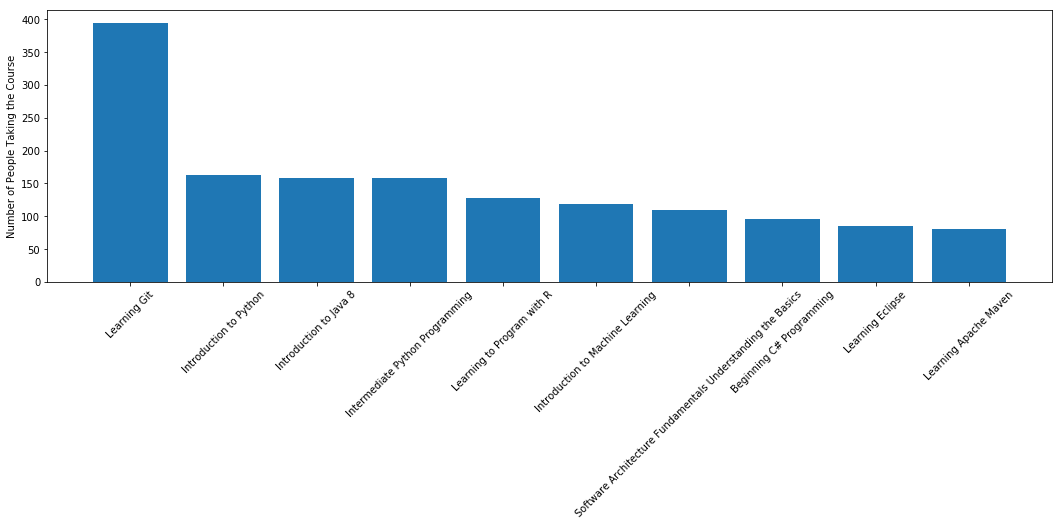

In [69]:
# Presenting the top 10 - most popular courses
xt = range(0,10)
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18,5))
ax1.bar(xt, y)
plt.xticks(xt, x)
plt.xticks(rotation=45)
ax1.set_ylabel("Number of People Taking the Course")
plt.show()

**7. Query including AVERAGE for total and correct questions:**

** What classes have the highest and lowest percent of correct questions?**

#Create a View with Average Total Questions and Average Correct Questions

In [54]:
questions_avg.registerTempTable('exam_avg_view')

* 7.1 What classes have the highest percent of correct questions?*

In [55]:
spark.sql("select exam_name, num_exam, avg_correct/avg_total as percent  from exam_avg_view ORDER BY percent DESC limit 5").show()

+--------------------+--------+------------------+
|           exam_name|num_exam|           percent|
+--------------------+--------+------------------+
|Learning to Visua...|       1|               1.0|
|The Closed World ...|       2|               1.0|
|Nulls, Three-valu...|       1|               1.0|
|Learning SQL for ...|      11|0.9772727272727273|
|Introduction to J...|     158|0.8759493670886076|
+--------------------+--------+------------------+



* 7.2 What classes have the lowest percent of correct questions?*

In [56]:
spark.sql("select exam_name, num_exam, avg_correct/avg_total as percent  from exam_avg_view ORDER BY percent limit 5").show()

+--------------------+--------+------------------+
|           exam_name|num_exam|           percent|
+--------------------+--------+------------------+
|Example Exam For ...|       5|              null|
|Client-Side Data ...|       2|               0.2|
|Native Web Apps f...|       1|              0.25|
|       View Updating|       4|              0.25|
|Arduino Prototypi...|       2|0.3333333333333333|
+--------------------+--------+------------------+



### IV. Structure for 'docker-compose.yml' file:

```
---
version: '2'
services:
  zookeeper:
    image: confluentinc/cp-zookeeper:latest
    environment:
      ZOOKEEPER_CLIENT_PORT: 32181
      ZOOKEEPER_TICK_TIME: 2000
    expose:
      - "2181"
      - "2888"
      - "32181"
      - "3888"

  kafka:
    image: confluentinc/cp-kafka:latest
    depends_on:
      - zookeeper
    environment:
      KAFKA_BROKER_ID: 1
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:32181
      KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://kafka:29092
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    expose:
      - "9092"
      - "29092"

  cloudera:
    image: midsw205/cdh-minimal:latest
    expose:
      - "8020" # nn
      - "50070" # nn http
      - "8888" # hue
    #ports:
    #- "8888:8888"

  spark:
    image: midsw205/spark-python:0.0.5
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205
    command: bash
    depends_on:
      - cloudera
    environment:
      HADOOP_NAMENODE: cloudera
    expose:
      - "7000"
    ports:
      - "7000:7000"

  mids:
    image: midsw205/base:latest
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205
```

### V. Top Line Structure of JSON File:

```
{
  "keen_timestamp": "1516717442.735266",
  "max_attempts": "1.0",
  "started_at": "2018-01-23T14:23:19.082Z",
  "base_exam_id": "37f0a30a-7464-11e6-aa92-a8667f27e5dc",
  "user_exam_id": "6d4089e4-bde5-4a22-b65f-18bce9ab79c8",
  "sequences": {
    "questions": [
      {
        "user_incomplete": true,
        "user_correct": false,
        "options": [
          {
            "checked": true,
            "at": "2018-01-23T14:23:24.670Z",
            "id": "49c574b4-5c82-4ffd-9bd1-c3358faf850d",
            "submitted": 1,
            "correct": true
          },
          {
            "checked": true,
            "at": "2018-01-23T14:23:25.914Z",
            "id": "f2528210-35c3-4320-acf3-9056567ea19f",
            "submitted": 1,
            "correct": true
          },
          {
            "checked": false,
            "correct": true,
            "id": "d1bf026f-554f-4543-bdd2-54dcf105b826"
          }
        ],
        "user_submitted": true,
        "id": "7a2ed6d3-f492-49b3-b8aa-d080a8aad986",
        "user_result": "missed_some"
      },
      {
        "user_incomplete": false,
        "user_correct": false,
        "options": [
          {
            "checked": true,
            "at": "2018-01-23T14:23:30.116Z",
            "id": "a35d0e80-8c49-415d-b8cb-c21a02627e2b",
            "submitted": 1
          },
          {
            "checked": false,
            "correct": true,
            "id": "bccd6e2e-2cef-4c72-8bfa-317db0ac48bb"
          },
          {
            "checked": true,
            "at": "2018-01-23T14:23:41.791Z",
            "id": "7e0b639a-2ef8-4604-b7eb-5018bd81a91b",
            "submitted": 1,
            "correct": true
          }
        ],
        "user_submitted": true,
        "id": "bbed4358-999d-4462-9596-bad5173a6ecb",
        "user_result": "incorrect"
      },
      {
        "user_incomplete": false,
        "user_correct": true,
        "options": [
          {
            "checked": false,
            "at": "2018-01-23T14:23:52.510Z",
            "id": "a9333679-de9d-41ff-bb3d-b239d6b95732"
          },
          {
            "checked": false,
            "id": "85795acc-b4b1-4510-bd6e-41648a3553c9"
          },
          {
            "checked": true,
            "at": "2018-01-23T14:23:54.223Z",
            "id": "c185ecdb-48fb-4edb-ae4e-0204ac7a0909",
            "submitted": 1,
            "correct": true
          },
          {
            "checked": true,
            "at": "2018-01-23T14:23:53.862Z",
            "id": "77a66c83-d001-45cd-9a5a-6bba8eb7389e",
            "submitted": 1,
            "correct": true
          }
        ],
        "user_submitted": true,
        "id": "e6ad8644-96b1-4617-b37b-a263dded202c",
        "user_result": "correct"
      },
      {
        "user_incomplete": false,
        "user_correct": true,
        "options": [
          {
            "checked": false,
            "id": "59b9fc4b-f239-4850-b1f9-912d1fd3ca13"
          },
          {
            "checked": false,
            "id": "2c29e8e8-d4a8-406e-9cdf-de28ec5890fe"
          },
          {
            "checked": false,
            "id": "62feee6e-9b76-4123-bd9e-c0b35126b1f1"
          },
          {
            "checked": true,
            "at": "2018-01-23T14:24:00.807Z",
            "id": "7f13df9c-fcbe-4424-914f-2206f106765c",
            "submitted": 1,
            "correct": true
          }
        ],
        "user_submitted": true,
        "id": "95194331-ac43-454e-83de-ea8913067055",
        "user_result": "correct"
      }
    ],
    "attempt": 1,
    "id": "5b28a462-7a3b-42e0-b508-09f3906d1703",
    "counts": {
      "incomplete": 1,
      "submitted": 4,
      "incorrect": 1,
      "all_correct": false,
      "correct": 2,
      "total": 4,
      "unanswered": 0
    }
  },
  "keen_created_at": "1516717442.735266",
  "certification": "false",
  "keen_id": "5a6745820eb8ab00016be1f1",
  "exam_name": "Normal Forms and All That Jazz Master Class"
```

### VI. File and Other Information about this Project:

(a) The file used for this project was downloaded using the following command:

```
curl -L -o assessment-attempts-20180128-121051-nested.json https://goo.gl/ME6hjp
```
(b) This file is in JSON format with 10 fields at the main level: (1) 'keen_timestamp', (2) 'max_attempts', (3) 'started_at', (4) 'base_exam_id', (5) 'user_exam_id', (6) 'sequences', (7) 'keen_created_at', (8) 'certification', (9) 'keen_id', (10) 'exam_name'.  

In addition, the field **"sequences"** has four nested levels which are: 'questions', 'attempt', 'id' and 'counts'.    

Among the nested fields within sequences, **questions** amd **counts** have additional nested fields.  The field **counts** summarize key results of the test in the following fields: (a) 'incomplete', (b) 'submitted', (c) 'incorrect', (d) 'all_correct', (e) 'correct', (f) 'total', (g) 'unanswered'.  These fields may be useful to understand performance for students taking these exams or courses.

An example of one of the JSON entries is included in section V in this document.

(c) This project was implemented using a 'docker-compose' including the following services: zookeeper, kafka, spark, and MIDS. The docker-compose.yml file structure is included in section IV in this document.

(d) A kafka topic (examtaken) was created and used to send the information to be analyzed using pyspark/spark.sql. 

